# Hyperbolic VAE
Open in Google Colab. Upload provided data ("cleaned_Multiome.csv" "cleaned_RNA.csv" "cleaned_colData.csv") to "\content"

Run from top to bottom and the model will run.

# Install and import libraries

In [1]:
!pip install evaluate
!pip install --upgrade torch transformers
!pip install geoopt
!pip install torchtyping

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.1 MB/s eta 0:00:00
   ━

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import json
import glob
import itertools
from PIL import Image
import pandas as pd

cudnn.benchmark = True
plt.ion()

# Data Processing

In [17]:
class BioDataset(torch.utils.data.Dataset):
    def __init__(self, rna_path, mult_path, cell_type_path, is_train):
        self.rna = []
        self.shared = []
        self.mult = []
        self.cell_type = []

        atac_data = pd.read_csv(rna_path, index_col=0)
        mult_data = pd.read_csv(mult_path, index_col=0)
        cell_type = pd.read_csv(cell_type_path, index_col=0)

        atac_data = atac_data.T
        mult_data = mult_data.T

        atac_data = atac_data.iloc[1:]
        mult_data = mult_data.iloc[1:]

        atac_data = atac_data.join(cell_type)
        mult_data = mult_data.join(cell_type)

        atac_cell_types = []
        mult_data_cell_types = []

        for i in range(len(atac_data)):
            atac_cell_types.append(atac_data.iloc[i]["broad_celltype"])
        for i in range(len(mult_data)):
            mult_data_cell_types.append(mult_data.iloc[i]["broad_celltype"])

        if is_train:
          self.cell_type = atac_cell_types
        else:
          self.cell_type = mult_data_cell_types

        atac_data = atac_data.drop(columns=cell_type.columns)
        mult_data = mult_data.drop(columns=cell_type.columns)

        atac_data = atac_data.astype(float)
        mult_data = mult_data.astype(float)

        colNames = atac_data.columns.intersection(mult_data.columns)

        colNames_atac = atac_data.columns.difference(mult_data.columns)
        colNames_mult = mult_data.columns.difference(atac_data.columns)

        print(len(colNames))
        print(len(colNames_atac))
        print(len(colNames_mult))

        if is_train:
          # Loop through atac_data
          for i in range(len(atac_data)):
              # Add values in atac_data that are not in colNames to rna
              rna_values = atac_data.iloc[i][~atac_data.columns.isin(colNames)].tolist()
              self.rna.append(rna_values)

              # Add values in atac_data that are in colNames to shared
              shared_values = atac_data.iloc[i][atac_data.columns.isin(colNames)].tolist()
              self.shared.append(shared_values)

              # Create values of length colNames_mult and add to mult
              mult_values = [-1998] * len(colNames_mult)
              self.mult.append(mult_values)
        else:
          # Loop through mult_data
          for i in range(len(mult_data)):
              # Add values in mult_data that are not in colNames to mult
              mult_values = mult_data.iloc[i][~mult_data.columns.isin(colNames)].tolist()
              self.mult.append(mult_values)

              # Add values in mult_data that are in colNames to shared
              shared_values = mult_data.iloc[i][mult_data.columns.isin(colNames)].tolist()
              self.shared.append(shared_values)

              # Create values of length colNames_atac and add to rna
              rna_values = [-1998] * len(colNames_atac)
              self.rna.append(rna_values)

        assert len(self.rna) == len(self.shared)
        assert len(self.rna) == len(self.mult)
        assert len(self.rna) == len(self.cell_type)

        self._check_for_nan()

    def _check_for_nan(self):
        for i in range(len(self.rna)):
            if (np.isnan(self.rna[i]).any() or
                np.isnan(self.shared[i]).any() or
                np.isnan(self.mult[i]).any()):
                raise ValueError(f"NaN value found at index {i}")

    def __len__(self):
        return len(self.rna)

    def __getitem__(self, idx):
        return {
            "rna": self.rna[idx],
            "shared": self.shared[idx],
            "atac": self.mult[idx],
            "cell_type": self.cell_type[idx]
        }

In [18]:
def collate_fn(batch):
    rna = [item['rna'] for item in batch]
    shared = [item['shared'] for item in batch]
    atac = [item['atac'] for item in batch]
    cell_types = [item['cell_type'] for item in batch]

    if len(rna[0]) == 0:
      rna = [[-1998] * 25] * len(rna)
    if len(shared[0]) == 0:
      shared = [[-1998] * 25] * len(shared)
    if len(atac[0]) == 0:
      atac = [[-1998] * 25] * len(atac)

    rna_tensor = torch.tensor(rna, dtype=torch.float32)
    shared_tensor = torch.tensor(shared, dtype=torch.float32)
    atac_tensor = torch.tensor(atac, dtype=torch.float32)

    rna_mask = (rna_tensor != -1998).bool()
    shared_mask = (shared_tensor != -1998).bool()
    atac_mask = (atac_tensor != -1998).bool()

    return {
        'rna': rna_tensor,
        'rna_attention_mask': rna_mask,
        'shared': shared_tensor,
        'shared_attention_mask': shared_mask,
        'atac': atac_tensor,
        'atac_attention_mask': atac_mask,
        'cell_type': cell_types
    }

In [19]:
# Create the train/eval/test datasets
dataset = BioDataset('/content/cleaned_RNA.csv', '/content/cleaned_Multiome.csv', '/content/cleaned_colData.csv', True)
test_dataset = BioDataset('/content/cleaned_RNA.csv', '/content/cleaned_Multiome.csv', '/content/cleaned_colData.csv', False)

952
0
788
952
0
788


In [20]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

rna_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
multi_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

# Hyperbolic Manifolds for VAE

In [9]:
"""
Tools for generating Riemannian manifolds and product manifolds.

The module consists of two classes: Manifold and ProductManifold .The Manifold class
represents hyperbolic, Euclidean, or spherical manifolds based on curvature.
The ProductManifold class supports products of multiple manifolds,
combining their geometric properties to create mixed-curvature. Both classes
includes functions for different key geometric operations.
"""
from typing import List, Optional, Tuple, Union
import torch
import geoopt
from torchtyping import TensorType as TT


class Manifold:
    """
    Tools for generating Riemannian manifolds.

    Parameters
    ----------
    curvature: (float) The curvature of the manifold. Negative for hyperbolic,
    zero for Euclidean, and positive for spherical manifolds.
    dim: (int) The dimension of the manifold.
    device: (str) The device on which the manifold is stored (default: "cpu").

    """
    def __init__(self, curvature: float, dim: int, device: str = "cpu"):
        # Device management
        self.device = device

        # Basic properties
        self.curvature = curvature
        self.dim = dim
        self.scale = abs(curvature) ** -0.5 if curvature != 0 else 1

        # A couple of manifold-specific quirks we need to deal with here
        if curvature < 0:
            self.type = "H"
            man = geoopt.Lorentz(k=1.0)
            # Use 'k=1.0' because the scale will take care of the curvature
            # For more information, see the bottom of page 5 of Gu et al. (2019):
            # https://openreview.net/pdf?id=HJxeWnCcF7
        elif curvature == 0:
            self.type = "E"
            man = geoopt.Euclidean(ndim=1)
            # Use 'ndim=1' because dim means the *shape* of the Euclidean space, not the dimensionality...
        else:
            self.type = "S"
            man = geoopt.Sphere()
        self.manifold = geoopt.Scaled(man, self.scale, learnable=True).to(self.device)

        self.ambient_dim = dim if curvature == 0 else dim + 1
        if curvature == 0:
            self.mu0 = torch.zeros(self.dim).to(self.device).reshape(1, -1)
        else:
            self.mu0 = torch.Tensor([1.0] + [0.0] * dim).to(self.device).reshape(1, -1)
        self.name = f"{self.type}_{abs(self.curvature):.1f}^{dim}"

        # Couple of assertions to check
        assert self.manifold.check_point(self.mu0)

    def to(self, device: str):
        """
        Move objects to a specified device

        Args:
            device: (str) The device to which the manifold will be moved.

        Returns:
            self: The updated manifold object.
        """
        self.device = device
        self.manifold = self.manifold.to(device)
        self.mu0 = self.mu0.to(device)
        return self

    def inner(self, X: TT["n_points1", "n_dim"], Y: TT["n_points2", "n_dim"]) -> TT["n_points1", "n_points2"]:
        """
        Compute the inner product of manifolds.

        Args:
            X: (n_points1, n_dim) Tensor of points in the manifold.
            Y: (n_points2, n_dim) Tensor of points in the manifold.

        Returns:
            inner_product: (n_points1, n_points2) Tensor of inner products between points.
        """
        # "Not inherited because of weird broadcasting stuff, plus need for scale.
        # This ensures we compute the right inner product for all manifolds (flip sign of dim 0 for hyperbolic)
        X_fixed = torch.cat([-X[:, 0:1], X[:, 1:]], dim=1) if self.type == "H" else X

        # This prevents dividing by zero in the Euclidean case
        scaler = 1 / abs(self.curvature) if self.type != "E" else 1
        return X_fixed @ Y.T * scaler

    def dist(self, X: TT["n_points1", "n_dim"], Y: TT["n_points2", "n_dim"]) -> TT["n_points1", "n_points2"]:
        """
        Inherit distance function from the geoopt manifold.

        Args:
            X: (n_points1, n_dim) Tensor of points in the manifold.
            Y: (n_points2, n_dim) Tensor of points in the manifold.

        Returns:
            distance: (n_points1, n_points2) Tensor of distances between points.
        """
        # if self.type == "E":
        #     return self.manifold.dist(X[:, None], Y[None, :]).norm(dim=-1)
        # else:
        return self.manifold.dist(X[:, None], Y[None, :])

    def dist2(self, X: TT["n_points1", "n_dim"], Y: TT["n_points2", "n_dim"]) -> TT["n_points1", "n_points2"]:
        """
        Inherit squared distance function from the geoopt manifold.

        Args:
            X: (n_points1, n_dim) Tensor of points in the manifold.
            Y: (n_points2, n_dim) Tensor of points in the manifold.

        Returns:
            distance: (n_points1, n_points2) Tensor of squared distances between points.
        """
        # if self.type == "E":
        #     return self.manifold.dist2(X[:, None], Y[None, :]).sum(dim=-1)
        # else:
        return self.manifold.dist2(X[:, None], Y[None, :])

    def pdist(self, X: TT["n_points", "n_dim"]) -> TT["n_points", "n_points"]:
        """
        Compute pairwise distances between embeddings.

        Args:
            X: (n_points, n_dim) Tensor of points in the manifold.

        Returns:
            dists: (n_points, n_points) Tensor of pairwise distances.
        """
        # if self.type == "E":
        #     dists = self.dist(X, X).norm(dim=-1)
        # else:
        dists = self.dist(X, X)

        # Fill diagonal with zeros
        dists.fill_diagonal_(0.0)

        return dists

    def pdist2(self, X: TT["n_points", "n_dim"]) -> TT["n_points", "n_points"]:
        """
        Compute pairwise squared distances between embeddings.

        Args:
            X: (n_points, n_dim) Tensor of points in the manifold.

        Returns:
            dists2: (n_points, n_points) Tensor of squared distances.
        """
        # if self.type == "E":
        #     dists2 = self.dist2(X, X).sum(dim=-1)
        # else:
        dists2 = self.dist2(X, X)

        dists2.fill_diagonal_(0.0)

        return dists2

    def _to_tangent_plane_mu0(self, x: TT["n_points", "n_dim"]) -> TT["n_points", "n_ambient_dim"]:
        """Map points to the tangent plane at the origin of the manifold."""
        x = torch.Tensor(x).reshape(-1, self.dim)
        if self.type == "E":
            return x
        else:
            return torch.cat([torch.zeros((x.shape[0], 1), device=self.device), x], dim=1)

    def sample(
        self,
        z_mean: Optional[TT["n_points", "n_ambient_dim"]] = None,
        sigma: Optional[TT["n_points", "n_dim", "n_dim"]] = None,
        return_tangent: bool = False,
    ) -> Union[TT["n_points", "n_ambient_dim"], Tuple[TT["n_points", "n_ambient_dim"], TT["n_points", "n_dim"]]]:
        """
        Sample from the variational distribution.

        Args:
            z_mean: (n_points, n_dim) Tensor representing the mean of the sample distribution. Defaults to `self.mu0`.
            sigma_factorized: List of tensors representing factorized covariance matrices for each manifold.
            return_tangent: Bool for whether to return the tangent vectors along with the sampled points.

        Returns:
            Tensor or tuple of tensor(n_points, n_ambient_dim) representing the sampled points on the manifold.
            If `return_tangent` is True, also returns the tangent vectors with shape `(n_points, n_dim)`.
        """
        if z_mean is None:
            z_mean = self.mu0
        z_mean = torch.Tensor(z_mean).reshape(-1, self.ambient_dim).to(self.device)
        n = z_mean.shape[0]
        if sigma is None:
            sigma = torch.stack([torch.eye(self.dim)] * n).to(self.device)
        else:
            sigma = torch.Tensor(sigma).reshape(-1, self.dim, self.dim).to(self.device)
        assert sigma.shape == (n, self.dim, self.dim)
        # assert torch.all(sigma == sigma.transpose(-1, -2))
        assert z_mean.shape[-1] == self.ambient_dim

        # Sample initial vector from N(0, sigma)
        N = torch.distributions.MultivariateNormal(torch.zeros((n, self.dim), device=self.device), sigma)
        v = N.sample(sample_shape=(1,)).reshape(n, self.dim)  # TODO: allow for other numbers of samples

        # Don't need to adjust normal vectors for the Scaled manifold class in geoopt - very cool!

        # Enter tangent plane
        v_tangent = self._to_tangent_plane_mu0(v)

        # Move to z_mean via parallel transport
        z = self.manifold.transp(x=self.mu0, y=z_mean, v=v_tangent)

        # If we're sampling at the origin, z and v should be the same
        mask = torch.all(z == self.mu0, dim=1)
        assert torch.allclose(v_tangent[mask], z[mask])

        # Exp map onto the manifold
        x = self.manifold.expmap(x=z_mean, u=z)

        # Different return types
        if return_tangent:
            return x, v
        else:
            return x

    def log_likelihood(
        self,
        z: TT["n_points", "n_ambient_dim"],
        mu: Optional[TT["n_points", "n_ambient_dim"]] = None,
        sigma: Optional[TT["n_points", "n_dim", "n_dim"]] = None,
    ) -> TT["n_points"]:
        """
        Probability density function for WN(z ; mu, Sigma) in manifold

        Args:
            z: (n_points", "n_ambient_dim) Tensor of points on the manifold for which the likelihood is computed.
            mu: (n_points", "n_ambient_dim) Tensor representing the mean of the distribution. Defaults to `self.mu0`.
            sigma: (n_points", "n_dim", "n_dim) Tensor representing the covariance matrix. Defaults to the identity matrix.

        Returns:
            (n_points) Tensor containing the log-likelihood of the points `z` under the distribution
            with mean `mu` and covariance `sigma.`

        """

        # Default to mu=self.mu0 and sigma=I
        if mu is None:
            mu = self.mu0
        mu = torch.Tensor(mu).reshape(-1, self.ambient_dim).to(self.device)
        if sigma is None:
            sigma = torch.stack([torch.eye(self.dim)] * n).to(self.device)
        else:
            sigma = torch.Tensor(sigma).reshape(-1, self.dim, self.dim).to(self.device)

        # Euclidean case is regular old Gaussian log-likelihood
        if self.type == "E":
            return torch.distributions.MultivariateNormal(mu, sigma).log_prob(z)

        elif self.type in ["S", "H"]:
            u = self.manifold.logmap(x=mu, y=z)  # Map z to tangent space at mu
            v = self.manifold.transp(x=mu, y=self.mu0, v=u)  # Parallel transport to origin
            # assert torch.allclose(v[:, 0], torch.Tensor([0.])) # For tangent vectors at origin this should be true
            # OK, so this assertion doesn't actually pass, but it's spiritually true
            if torch.isnan(v).any():
                print("NANs in parallel transport")
                v = torch.nan_to_num(v, nan=0.0)
            N = torch.distributions.MultivariateNormal(torch.zeros(self.dim, device=self.device), sigma)
            ll = N.log_prob(v[:, 1:])

            # For convenience
            R = self.scale
            n = self.dim

            # Final formula (epsilon to avoid log(0))
            if self.type == "S":
                sin_M = torch.sin
                u_norm = self.manifold.norm(x=mu, u=u)

            elif self.type == "H":
                sin_M = torch.sinh
                u_norm = self.manifold.base.norm(u=u)  # Horrible workaround needed for geoopt bug

            return ll - (n - 1) * torch.log(R * torch.abs(sin_M(u_norm / R) / u_norm) + 1e-8)

    def logmap(self, x, base=None):
        """
        Logarithmic map of point on manifold x at base point.

        Args:
            x: Tensor representing the point on the manifold for the logarithmic map.
            base: Tensor representing the base point for the map. Defaults to `self.mu0` if not provided.

        Returns:
            Tensor representing the result of the logarithmic map from `base` to `x` on the manifold.

        """
        if base is None:
            base = self.mu0
        return self.manifold.logmap(x=base, y=x)

    def expmap(self, u, base=None):
        """
        Exponential map of tangent vector u at base point
        Args:
            u: Tensor representing the tangent vector at the base point to map.
            base: Tensor representing the base point for the exponential map. Defaults to `self.mu0` if not provided.

        Returns:
            Tensor representing the result of the exponential map applied to `u` at the base point.
        """
        if base is None:
            base = self.mu0
        return self.manifold.expmap(x=base, u=u)


class ProductManifold(Manifold):
    """
    Tools for generating Riemannian manifolds.

    Parameters
    ----------
    Signature: (Tuple[float, int]) A list for the signature for the product manifold
    device: (str) The device on which the manifold is stored (default: "cpu").
    """
    def __init__(self, signature: List[Tuple[float, int]], device: str = "cpu"):
        # Device management
        self.device = device

        # Basic properties
        self.type = "P"
        self.signature = signature
        self.curvatures = [curvature for curvature, _ in signature]
        self.dims = [dim for _, dim in signature]
        self.n_manifolds = len(signature)

        # Actually initialize the geoopt manifolds; other derived properties
        self.P = [Manifold(curvature, dim, device=device) for curvature, dim in signature]
        self.manifold = geoopt.ProductManifold(*[(M.manifold, M.ambient_dim) for M in self.P])
        self.name = " x ".join([M.name for M in self.P])

        # Origin
        self.mu0 = torch.cat([M.mu0 for M in self.P], axis=1).to(self.device)

        # Manifold <-> Dimension mapping
        self.ambient_dim, self.n_manifolds, self.dim = 0, 0, 0
        self.dim2man, self.man2dim, self.man2intrinsic, self.intrinsic2man = {}, {}, {}, {}

        for M in self.P:
            for d in range(self.ambient_dim, self.ambient_dim + M.ambient_dim):
                self.dim2man[d] = self.n_manifolds
            for d in range(self.dim, self.dim + M.dim):
                self.intrinsic2man[d] = self.n_manifolds
            self.man2dim[self.n_manifolds] = list(range(self.ambient_dim, self.ambient_dim + M.ambient_dim))
            self.man2intrinsic[self.n_manifolds] = list(range(self.dim, self.dim + M.dim))

            self.ambient_dim += M.ambient_dim
            self.n_manifolds += 1
            self.dim += M.dim

        # Lift matrix - useful for tensor stuff
        # The idea here is to right-multiply by this to lift a vector in R^dim to a vector in R^ambient_dim
        # such that there are zeros in all the right places, i.e. to make it a tangent vector at the origin of P
        self.projection_matrix = torch.zeros(self.dim, self.ambient_dim, device=self.device)
        for i in range(len(self.P)):
            intrinsic_dims = self.man2intrinsic[i]
            ambient_dims = self.man2dim[i]
            for j, k in zip(intrinsic_dims, ambient_dims[-len(intrinsic_dims) :]):
                self.projection_matrix[j, k] = 1.0

    def params(self):
        return [x._log_scale for x in self.manifold.manifolds]

    def to(self, device: str):
        self.device = device
        self.P = [M.to(device) for M in self.P]
        self.manifold = self.manifold.to(device)
        self.mu0 = self.mu0.to(device)
        self.projection_matrix = self.projection_matrix.to(device)
        return self

    def initialize_embeddings(
        self, n_points: int, scales: Union[List[float], float] = 1.0
    ) -> TT["n_points", "n_ambient_dim"]:
        """
        Randomly initialize n_points embeddings on the product manifold.

        This method generates random embeddings for a specified number of points on
        the product manifold defined by the initialized manifolds in the object.
        The initialization is done according to the type of each manifold and is
        optionally scaled by the provided scales.

        Args:
            n_points: The number of embeddings to initialize.
            scales: A list of scale factors corresponding to each manifold in the product.
            If a single float is provided, it will be applied to all manifolds. Defaults to 1.0.

        Returns:
            TT["n_points", "n_ambient_dim"]: A tensor of shape (n_points, ambient_dim) representing
            the initialized embeddings in the ambient space of the product manifold.

        """
        # Scales management
        if not isinstance(scales, list):
            scales = [scales] * len(self.P)
        elif len(scales) != len(self.P):
            raise ValueError("The number of scales must match the number of manifolds.")

        x_embed = []
        for M, scale in zip(self.P, scales):
            if M.type == "H":
                x_embed.append(
                    M.manifold.expmap0(
                        u=torch.cat(
                            [
                                torch.zeros(n_points, 1, device=self.device),
                                scale * torch.randn(n_points, M.dim, device=self.device),
                            ],
                            dim=1,
                        )
                    )
                )
            elif M.type == "E":
                x_embed.append(scale * torch.randn(n_points, M.dim, device=self.device))
            elif M.type == "S":
                x_embed.append(M.manifold.random_uniform(n_points, M.ambient_dim).to(self.device))
            else:
                raise ValueError("Unknown manifold type")

        x_embed = torch.cat(x_embed, axis=1).to(self.device)
        # x_embed = geoopt.ManifoldParameter(x_embed, manifold=self.manifold)
        return x_embed

    def factorize(self, X: TT["n_points", "n_dim"], intrinsic=False) -> List[TT["n_points", "n_dim_manifold"]]:
        """
        Factorize the embeddings into the individual manifolds.

        Args:
            X: (n_points", "n_dim) tensor representing the embeddings to be factorized.
            intrinsic: bool for whether to use intrinsic dimensions of the manifolds. Defaults to False.

        Returns:
            (List[Tensor]) list of tensors representing the factorized embeddings in each manifold.
        """
        dims_dict = self.man2intrinsic if intrinsic else self.man2dim
        return [X[..., dims_dict[i]] for i in range(len(self.P))]

    def sample(
        self,
        z_mean: Optional[TT["n_points", "n_dim"]] = None,
        # sigma: Optional[TT["n_points", "n_dim", "n_dim"]] = None
        sigma_factorized: Optional[List[TT["n_points", "n_dim_manifold", "n_dim_manifold"]]] = None,
        return_tangent: bool = False,
    ) -> Union[TT["n_points", "n_ambient_dim"], Tuple[TT["n_points", "n_ambient_dim"], TT["n_points", "n_dim"]]]:
        """
        Sample from the variational distribution.

        Args:
            z_mean: (n_points, n_dim) Tensor representing the mean of the sample distribution. Defaults to `self.mu0`.
            sigma_factorized: List of tensors representing factorized covariance matrices for each manifold.
            return_tangent: Bool for whether to return the tangent vectors along with the sampled points.

        Returns:
            Tensor or tuple of tensor of shape `(n_points, n_ambient_dim)` representing the sampled points on the manifold.
            If `return_tangent` is True, also returns the tangent vectors with shape `(n_points, n_dim)`.
        """
        if z_mean is None:
            z_mean = self.mu0
        z_mean = torch.Tensor(z_mean).reshape(-1, self.ambient_dim).to(self.device)
        n = z_mean.shape[0]

        if sigma_factorized is None:
            sigma_factorized = [torch.stack([torch.eye(M.dim)] * n) for M in self.P]
        else:
            sigma_factorized = [
                torch.Tensor(sigma).reshape(-1, M.dim, M.dim).to(self.device)
                for M, sigma in zip(self.P, sigma_factorized)
            ]

        assert sum([sigma.shape == (n, M.dim, M.dim) for M, sigma in zip(self.P, sigma_factorized)]) == len(self.P)
        assert z_mean.shape[-1] == self.ambient_dim

        # Sample initial vector from N(0, sigma)
        # x = torch.cat(
        #     [M.sample(z_M, sigma_M) for M, z_M, sigma_M in zip(self.P, self.factorize(z_mean), sigma_factorized)],
        #     dim=1,
        # )
        samples = [
            M.sample(z_M, sigma_M, return_tangent=True)
            for M, z_M, sigma_M in zip(self.P, self.factorize(z_mean), sigma_factorized)
        ]

        x = torch.cat([s[0] for s in samples], dim=1)
        v = torch.cat([s[1] for s in samples], dim=1)

        if return_tangent:
            return x, v
        else:
            return x

    def log_likelihood(
        self,
        z: TT["batch_size", "n_dim"],
        mu: Optional[TT["n_dim",]] = None,
        # sigma: TT["n_intrinsic_dim", "n_intrinsic_dim"] = None,
        sigma_factorized: Optional[List[TT["n_points", "n_dim_manifold", "n_dim_manifold"]]] = None,
    ) -> TT["batch_size"]:
        """
        Probability density function for WN(z ; mu, Sigma) in manifold

        Args:
            z: (batch_size, n_dim) Tensor representing the points for which the log-likelihood is computed.
            mu: (n_dim,) Tensor representing the mean of the distribution.
            sigma_factorized: List of tensors representing factorized covariance matrices for each manifold.

        Returns:
            (batch_size,) Tensor of shape containing the log-likelihood
            of each point in `z`  with mean `mu` and covariance `sigma`.
        """
        n = z.shape[0]
        if mu is None:
            mu = torch.stack([self.mu0] * n).to(self.device)

        if sigma_factorized is None:
            sigma_factorized = [torch.stack([torch.eye(M.dim)] * n) for M in self.P]
            # Note that this factorization assumes block-diagonal covariance matrices

        mu_factorized = self.factorize(mu)
        z_factorized = self.factorize(z)
        component_lls = [
            M.log_likelihood(z_M, mu_M, sigma_M).unsqueeze(dim=1)
            for M, z_M, mu_M, sigma_M in zip(self.P, z_factorized, mu_factorized, sigma_factorized)
        ]
        return torch.cat(component_lls, axis=1).sum(axis=1)


# Hyperbolic VAE

In [11]:
from typing import List
from torchtyping import TensorType as TT
import torch

# from .manifolds import ProductManifold

class ProductSpaceVAE(torch.nn.Module):
    """
    Variational Autoencoder (VAE) for data in a mixed-curvature product manifold space.
    This VAE model leverages a product manifold structure for latent representations, enabling
    flexible encodings in spaces with different curvature properties (e.g., hyperbolic, Euclidean, spherical).
    """
    def __init__(
        self,
        encoder: torch.nn.Module,
        decoder: torch.nn.Module,
        pm: ProductManifold,
        beta: float = 1.0,
        reconstruction_loss: str = "mse",
        device: str = "cpu",
        n_samples=16,
    ):
        super(ProductSpaceVAE, self).__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.pm = pm.to(device)
        self.beta = beta
        self.device = device
        self.n_samples = n_samples

        if reconstruction_loss == "mse":
            self.reconstruction_loss = torch.nn.MSELoss(reduction="none")
        else:
            raise ValueError(f"Unknown reconstruction loss: {reconstruction_loss}")

    def encode(
        self,
        x: TT["batch_size", "n_features"],
        *args  # Accept additional arguments for the encoder
    ) -> (TT["batch_size", "n_latent"], TT["batch_size", "n_latent"]):
        """Must return z_mean, z_logvar"""
        return self.encoder(x, *args)

    def decode(self, z: TT["batch_size", "n_latent"]) -> TT["batch_size", "n_features"]:
        """Decoding in product space VAE"""
        return self.decoder(z)

    def forward(
        self,
        x: TT["batch_size", "n_features"],
        *args  # Forward additional arguments to encoder
    ) -> TT["batch_size", "n_features"]:
        """
        Performs the forward pass of the VAE.

        Encodes the input, samples latent variables, and decodes to reconstruct the input.

        Args:
            x (torch.Tensor): Input data of shape (batch_size, n_features).
            *args: Additional arguments for the encoder.

        Returns:
            tuple: Reconstructed data, latent means, and latent variances.
        """
        z_means, z_logvars, x_concat = self.encode(x, *args)  # Pass additional arguments to encoder
        sigma_factorized = self.pm.factorize(z_logvars, intrinsic=True)
        sigmas = [torch.diag_embed(torch.exp(z_logvar) + 1e-8) for z_logvar in sigma_factorized]
        z = self.pm.sample(z_means, sigmas)
        x_reconstructed, logit = self.decode(z)
        return x_reconstructed, z_means, sigmas, x_concat, logit

    def kl_divergence(
        self,
        z_mean: TT["batch_size", "n_latent"],
        sigma_factorized: List[TT["batch_size", "n_latent", "n_latent"]],
    ) -> TT["batch_size"]:
        """
        Computes the KL divergence between posterior and prior distributions.

        Args:
            z_mean (torch.Tensor): Latent means of shape (batch_size, n_latent).
            sigma_factorized (list of torch.Tensor): Factorized covariance matrices for each latent dimension.

        Returns:
            torch.Tensor: KL divergence values for each data point in the batch.
        """
        means = torch.repeat_interleave(z_mean, self.n_samples, dim=0)
        sigmas_factorized_interleaved = [
            torch.repeat_interleave(sigma, self.n_samples, dim=0) for sigma in sigma_factorized
        ]
        z_samples = self.pm.sample(means, sigmas_factorized_interleaved)
        log_qz = self.pm.log_likelihood(z_samples, means, sigmas_factorized_interleaved)
        log_pz = self.pm.log_likelihood(z_samples)
        return (log_qz - log_pz).view(-1, self.n_samples).mean(dim=1)

    def elbo(
        self,
        x: TT["batch_size", "n_features"],
        *args  # Accept additional arguments for the encoder
    ) -> TT["batch_size"]:
        """
        Computes the Evidence Lower Bound (ELBO) with additional encoder arguments.

        Args:
            x (torch.Tensor): Input data of shape (batch_size, n_features).
            *args: Additional arguments for the encoder.

        Returns:
            tuple: Mean ELBO, mean log-likelihood, and mean KL divergence across the batch.
        """
        x_reconstructed, z_means, sigma_factorized, x_concat, logit = self(x, *args)  # Forward pass with extra args
        kld = self.kl_divergence(z_means, sigma_factorized)
        ll = -self.reconstruction_loss(x_reconstructed.view(x.shape[0], -1), x_concat.view(x.shape[0], -1)).sum(dim=1)
        return (ll - self.beta * kld).mean(), ll.mean(), kld.mean(), logit


# Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoderLayer, TransformerEncoder
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import gc
from sklearn.metrics import jaccard_score
from sklearn.neighbors import NearestNeighbors
from torch.nn import CrossEntropyLoss
import torch.nn.init as init

if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

GPU is available


In [6]:
class Encoder(torch.nn.Module):
    def __init__(self, pm, hidden_dim, num_heads, num_layers, embedding_size, dropout=0.3, latent_dim=10):
        super().__init__()
        self.pm = pm

        for batch in train_loader:
            break

        def calculate_out_features(in_features):
            out_features = in_features // 5  # Divide by 10
            out_features = (out_features // 5) * 5  # Round down to the nearest multiple of 10
            # If out_features is 0 after rounding, set it to 10
            # out_features = 10 if out_features == 0 else out_features
            return out_features

        self.rna_out_features = calculate_out_features(batch["rna"].shape[1])
        self.shared_out_features = calculate_out_features(batch["shared"].shape[1])
        self.atac_out_features = calculate_out_features(batch["atac"].shape[1])

        self.original_rna_out_features = batch["rna"].shape[1]
        self.original_shared_out_features = batch["shared"].shape[1]
        self.original_atac_out_features = batch["atac"].shape[1]

        self.rna_encoder = TransformerEncoder(TransformerEncoderLayer(d_model=1, nhead=1, dropout=dropout, batch_first=True), num_layers=num_layers)
        self.shared_encoder = TransformerEncoder(TransformerEncoderLayer(d_model=1, nhead=1, dropout=dropout, batch_first=True), num_layers=num_layers)
        self.atac_encoder = TransformerEncoder(TransformerEncoderLayer(d_model=1, nhead=1, dropout=dropout, batch_first=True), num_layers=num_layers)

        self.rna_embedding = nn.Linear(batch["rna"].shape[1], batch["rna"].shape[1] * hidden_dim, bias=True)
        init.xavier_uniform_(self.rna_embedding.weight)

        self.shared_embedding = nn.Linear(batch["shared"].shape[1], batch["shared"].shape[1] * hidden_dim, bias=True)
        init.xavier_uniform_(self.shared_embedding.weight)

        self.atac_embedding = nn.Linear(batch["atac"].shape[1], batch["atac"].shape[1] * hidden_dim, bias=True)
        init.xavier_uniform_(self.atac_embedding.weight)

        encoder_layer = TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_mu = nn.Linear(hidden_dim, pm.dim)  # hidden_dim = 10, pm.dim = 10
        self.fc_log_var = nn.Linear(hidden_dim, pm.dim)

        self.classifier = nn.Linear(pm.ambient_dim, embedding_size)
        init.xavier_uniform_(self.classifier.weight)

        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim

    def forward(self, rna, rna_mask, shared, shared_mask, atac, atac_mask):
        rna = rna.to(device)
        rna_mask = rna_mask.to(device)
        shared = shared.to(device)
        shared_mask = shared_mask.to(device)
        atac = atac.to(device)
        atac_mask = atac_mask.to(device)

        rna = rna.unsqueeze(-1)
        shared = shared.unsqueeze(-1)
        atac = atac.unsqueeze(-1)

        rna = (rna - rna.mean(dim=1, keepdim=True)) / (rna.std(dim=1, keepdim=True) + 1e-8)
        shared = (shared - shared.mean(dim=1, keepdim=True)) / (shared.std(dim=1, keepdim=True) + 1e-8)
        atac = (atac - atac.mean(dim=1, keepdim=True)) / (atac.std(dim=1, keepdim=True) + 1e-8)

        rna = rna * rna_mask.unsqueeze(-1)
        shared = shared * shared_mask.unsqueeze(-1)
        atac = atac * atac_mask.unsqueeze(-1)

        rna = rna.squeeze(-1)
        shared = shared.squeeze(-1)
        atac = atac.squeeze(-1)

        rna_emb = self.rna_embedding(rna)
        shared_emb = self.shared_embedding(shared)
        atac_emb = self.atac_embedding(atac)

        rna_emb = rna_emb.view(rna.shape[0], self.original_rna_out_features, self.hidden_dim)
        shared_emb = shared_emb.view(shared.shape[0], self.original_shared_out_features, self.hidden_dim)
        atac_emb = atac_emb.view(atac.shape[0], self.original_atac_out_features, self.hidden_dim)

        x = torch.cat([rna_emb, shared_emb, atac_emb], dim=1)
        mask = torch.cat([rna_mask, shared_mask, atac_mask], dim=1)

        x = self.transformer_encoder(x)

        # Global average pooling
        x = x.sum(dim=1) / mask.sum(dim=1, keepdim=True)

        # Reparameterization trick
        z_mean_tangent = self.fc_mu(x)
        z_logvar = self.fc_log_var(x)
        z_mean = self.pm.manifold.expmap(x=self.pm.mu0, u=z_mean_tangent @ self.pm.projection_matrix)

        logits = self.classifier(z_mean)

        return z_mean, z_logvar, x, logits


class Decoder(torch.nn.Module):
    def __init__(self, pm, hidden_dim, embedding_size, dropout=0.3):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_size = embedding_size

        self.fc_dec = nn.Linear(pm.ambient_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, embedding_size)
        init.xavier_uniform_(self.classifier.weight)

        self.dropout = nn.Dropout(dropout)

    def forward(self, z_mean):
        x = self.fc_dec(z_mean)
        x = torch.relu(x)

        x = self.dropout(x)

        logits = self.classifier(x)
        return x, logits

In [7]:
import torch

def compute_jaccard_similarity(embeddings_omics1, embeddings_omics2, k=100):
    """
    Computes differentiable Jaccard similarity between nearest neighbors in two omics layers.

    Args:
        embeddings_omics1 (torch.Tensor): Embeddings for omics layer 1 (e.g., RNA).
        embeddings_omics2 (torch.Tensor): Embeddings for omics layer 2 (e.g., chromatin).
        k (int): Number of nearest neighbors to consider (default is 100).

    Returns:
        torch.Tensor: Mean Jaccard similarity across all cells.
    """
    num_cells_omics1 = embeddings_omics1.shape[0]
    num_cells_omics2 = embeddings_omics2.shape[0]

    combined_embeddings = torch.cat([embeddings_omics1, embeddings_omics2])

    distances = torch.cdist(combined_embeddings, combined_embeddings)

    _, neighbors = torch.topk(distances, k=k, largest=False, dim=1)

    jaccard_similarities = []

    for i in range(num_cells_omics1 + num_cells_omics2):
        set_omics1 = torch.zeros(num_cells_omics1 + num_cells_omics2, device=embeddings_omics1.device)
        set_omics2 = torch.zeros(num_cells_omics1 + num_cells_omics2, device=embeddings_omics1.device)

        set_omics1[neighbors[i]] = 1
        set_omics2[neighbors[i]] = 1

        if i < num_cells_omics1:
            set_omics1[num_cells_omics1:] = 0
        else:
            set_omics2[:num_cells_omics1] = 0

        intersection = torch.min(set_omics1, set_omics2).sum()
        union = torch.max(set_omics1, set_omics2).sum()

        jaccard_similarity = intersection / (union + 1e-8)  # Add small epsilon to avoid division by zero
        jaccard_similarities.append(jaccard_similarity)

    return torch.stack(jaccard_similarities).mean()

In [ ]:
hidden_dim = 6
num_heads = 2
num_layers = 4
embedding_size = 10

num_epochs = 10
learning_rate = 1e-4
jaccard_weight = 0

SIGNATURE = [(-1, 2)]
BETA = 1.0
N_SAMPLES = 32

# Skopek hyperparamters (aka standard Adam hyperparameters)
LR = 1e-4 # Was 1e-3 but I can't make it work
BETA1 = 0.9
BETA2 = 0.999
EPS = 1e-8
CURVATURE_LR = 1e-4

def compute_knn_accuracy(train_logits, train_labels, test_logits, test_labels, k=5):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_logits, train_labels)
    predictions = knn.predict(test_logits)
    return accuracy_score(test_labels, predictions)

pm = ProductManifold(SIGNATURE)
vae = ProductSpaceVAE(
    pm=pm, encoder=Encoder(pm, hidden_dim=hidden_dim, num_heads=num_heads, num_layers=num_layers,
    embedding_size=embedding_size), decoder=Decoder(pm, hidden_dim=hidden_dim,
    embedding_size=embedding_size), beta=BETA, n_samples=N_SAMPLES, device=device,)

opt = torch.optim.Adam(
    [{"params": vae.parameters(), "lr": LR * 0.1, "betas": (BETA1, BETA2), "eps": EPS},
     {"params": pm.params(), "lr": 0, "betas": (BETA1, BETA2), "eps": EPS}])
criterion = CrossEntropyLoss()

train_loss = []
test_loss = []

for epoch in range(num_epochs):
    total_loss = 0
    num_batches = len(train_loader)
    train_logits_list = []
    train_labels_list = []

    with tqdm(total=num_batches, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for batch_idx, batch in enumerate(train_loader):
            opt.zero_grad()

            rna = batch['rna']
            rna_mask = batch['rna_attention_mask']
            shared = batch['shared']
            shared_mask = batch['shared_attention_mask']
            atac = batch['atac']
            atac_mask = batch['atac_attention_mask']
            cell_types = batch['cell_type']

            _,_,_, logits = vae.encoder(rna, rna_mask, shared, shared_mask, atac, atac_mask)

            unique_labels = list(set(cell_types))
            label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
            numerical_labels = torch.tensor([label_to_index[label] for label in cell_types], device=device)

            # Compute cross-entropy loss
            loss = criterion(logits, numerical_labels)
            logits = logits.detach().cpu().numpy()
            loss.backward()
            opt.step()

            total_loss += loss.item()

            # Store logits and labels for KNN
            train_logits_list.append(logits)
            train_labels_list.extend(cell_types)

            pbar.update(1)
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{num_epochs} completed. Average Loss: {avg_loss:.4f}")
    train_loss.append(avg_loss)

    train_logits = np.concatenate(train_logits_list)
    train_labels = np.array(train_labels_list)
    train_accuracy = compute_knn_accuracy(train_logits, train_labels, train_logits, train_labels)
    print(f"Training Accuracy: {train_accuracy:.4f}")

    test_logits_list = []
    test_labels_list = []
    rna_embeddings_list = []
    multi_embeddings_list = []
    total_loss = 0
    num_batches = len(test_loader)

    with torch.no_grad():
        # Get RNA embeddings
        for batch in rna_loader:
            rna = batch['rna']
            rna_mask = batch['rna_attention_mask']
            shared = batch['shared']
            shared_mask = batch['shared_attention_mask']
            atac = batch['atac']  # Placeholder for atac in RNA data
            atac_mask = batch['atac_attention_mask']  # Placeholder for atac mask

            embeddings, _, _, _ = vae.encoder(rna, rna_mask, shared, shared_mask, atac, atac_mask)
            rna_embeddings_list.append(embeddings.cpu().numpy())

        # Get Multiome embeddings
        for batch in multi_loader:
            rna = batch['rna']  # Placeholder for rna in Multiome data
            rna_mask = batch['rna_attention_mask']  # Placeholder for rna mask
            shared = batch['shared']
            shared_mask = batch['shared_attention_mask']
            atac = batch['atac']
            atac_mask = batch['atac_attention_mask']

            embeddings, _, _, _ = vae.encoder(rna, rna_mask, shared, shared_mask, atac, atac_mask)
            multi_embeddings_list.append(embeddings.cpu().numpy())

        for batch in test_loader:
            rna = batch['rna']
            rna_mask = batch['rna_attention_mask']
            shared = batch['shared']
            shared_mask = batch['shared_attention_mask']
            atac = batch['atac']
            atac_mask = batch['atac_attention_mask']
            cell_types = batch['cell_type']

            _,_,_, logits = vae.encoder(rna, rna_mask, shared, shared_mask, atac, atac_mask)

            unique_labels = list(set(cell_types))
            label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
            numerical_labels = torch.tensor([label_to_index[label] for label in cell_types], device=device)

            # Compute cross-entropy loss
            loss = criterion(logits, numerical_labels)
            total_loss += loss.item()

            test_logits_list.append(logits.cpu().numpy())
            test_labels_list.extend(cell_types)

    test_logits = np.concatenate(test_logits_list)
    test_labels = np.array(test_labels_list)

    test_accuracy = compute_knn_accuracy(train_logits, train_labels, test_logits, test_labels)

    rna_embeddings = np.concatenate(rna_embeddings_list)
    multi_embeddings = np.concatenate(multi_embeddings_list)

    rna_embeddings = torch.tensor(rna_embeddings, dtype=torch.float32)
    multi_embeddings = torch.tensor(multi_embeddings, dtype=torch.float32)

    test_jaccard = compute_jaccard_similarity(rna_embeddings, multi_embeddings)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Jaccard Similarity: {test_jaccard:.4f}")
    test_loss.append(total_loss / num_batches)

print("Training completed!")

Epoch 1/10: 100%|██████████| 158/158 [01:02<00:00,  2.55it/s, loss=2.5095]


Epoch 1/10 completed. Average Loss: 2.8346
Training Accuracy: 0.9939
Test Accuracy: 0.6831
Test Jaccard Similarity: 0.9970


Epoch 2/10: 100%|██████████| 158/158 [01:04<00:00,  2.43it/s, loss=2.9108]


Epoch 2/10 completed. Average Loss: 2.7475
Training Accuracy: 0.9998
Test Accuracy: 0.6833
Test Jaccard Similarity: 0.9987


Epoch 3/10: 100%|██████████| 158/158 [01:04<00:00,  2.45it/s, loss=2.7729]


Epoch 3/10 completed. Average Loss: 2.7278
Training Accuracy: 0.9998
Test Accuracy: 0.6831
Test Jaccard Similarity: 0.9993


Epoch 4/10: 100%|██████████| 158/158 [01:04<00:00,  2.45it/s, loss=2.6951]


Epoch 4/10 completed. Average Loss: 2.7146
Training Accuracy: 0.9998
Test Accuracy: 0.6831
Test Jaccard Similarity: 0.9993


Epoch 5/10: 100%|██████████| 158/158 [01:04<00:00,  2.45it/s, loss=2.8784]


Epoch 5/10 completed. Average Loss: 2.7030
Training Accuracy: 0.9998
Test Accuracy: 0.6831
Test Jaccard Similarity: 0.9996


Epoch 6/10: 100%|██████████| 158/158 [01:04<00:00,  2.45it/s, loss=2.6065]


Epoch 6/10 completed. Average Loss: 2.6913
Training Accuracy: 0.9998
Test Accuracy: 0.6831
Test Jaccard Similarity: 0.9996


Epoch 7/10: 100%|██████████| 158/158 [01:04<00:00,  2.45it/s, loss=2.7275]


Epoch 7/10 completed. Average Loss: 2.6803
Training Accuracy: 1.0000
Test Accuracy: 0.6831
Test Jaccard Similarity: 0.9997


Epoch 8/10: 100%|██████████| 158/158 [01:04<00:00,  2.45it/s, loss=2.7822]


Epoch 8/10 completed. Average Loss: 2.6692
Training Accuracy: 1.0000
Test Accuracy: 0.6831
Test Jaccard Similarity: 0.9997


Epoch 9/10: 100%|██████████| 158/158 [01:04<00:00,  2.45it/s, loss=2.9056]


Epoch 9/10 completed. Average Loss: 2.6581
Training Accuracy: 1.0000
Test Accuracy: 0.6831
Test Jaccard Similarity: 0.9998


Epoch 10/10: 100%|██████████| 158/158 [01:04<00:00,  2.45it/s, loss=2.5594]


Epoch 10/10 completed. Average Loss: 2.6463
Training Accuracy: 1.0000
Test Accuracy: 0.6831
Test Jaccard Similarity: 0.9997
Training completed!


# Visualization

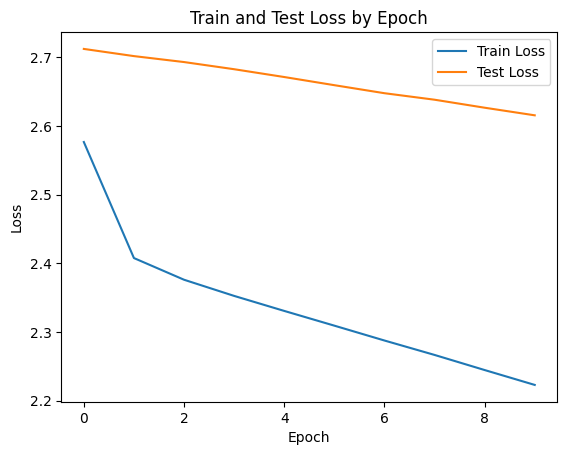

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss by Epoch')
plt.legend()
plt.show()

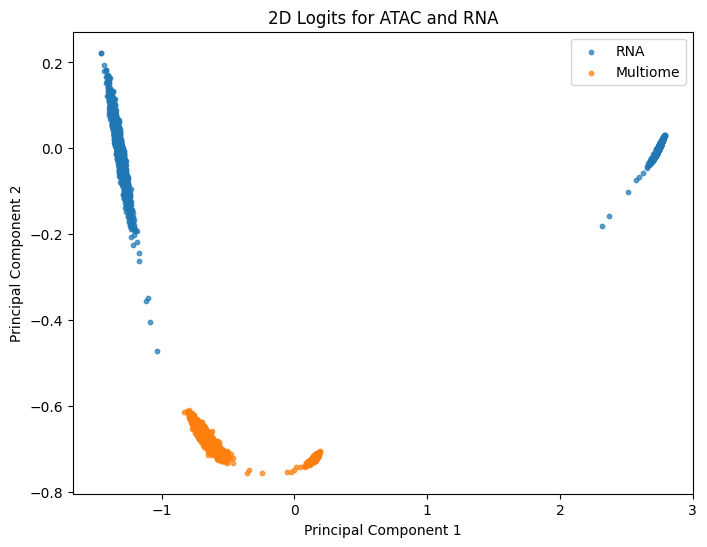

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'rna_embeddings' and 'multi_embeddings' are available from the training loop
# and are numpy arrays of shape (num_samples, embedding_dim)

# Reduce dimensionality for plotting (e.g., using PCA or t-SNE if embedding_dim > 2)
# If embedding_dim is already 2, skip this step.

from sklearn.decomposition import PCA

rna_embeddings_2d = rna_embeddings
multi_embeddings_2d = multi_embeddings
if rna_embeddings.shape[1] > 2:
  pca = PCA(n_components=2)
  rna_embeddings_2d = pca.fit_transform(rna_embeddings)
  multi_embeddings_2d = pca.transform(multi_embeddings)


plt.figure(figsize=(8, 6))
plt.scatter(rna_embeddings_2d[:, 0], rna_embeddings_2d[:, 1], label='RNA', alpha=0.7, s=10)
plt.scatter(multi_embeddings_2d[:, 0], multi_embeddings_2d[:, 1], label='Multiome', alpha=0.7, s=10)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D Logits for ATAC and RNA")
plt.legend()
plt.show()

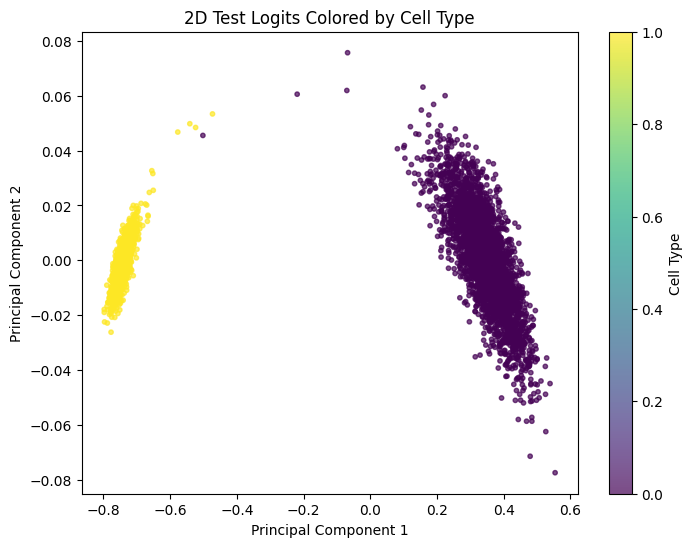

In [15]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'test_logits' and 'test_labels' are available from the training loop
# and are numpy arrays of shape (num_samples, embedding_dim) and (num_samples,) respectively.

# Reduce dimensionality for plotting if needed (e.g., using PCA)
test_logits_2d = test_logits
if test_logits.shape[1] > 2:
    pca = PCA(n_components=2)
    test_logits_2d = pca.fit_transform(test_logits)

label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(test_labels)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(test_logits_2d[:, 0], test_logits_2d[:, 1], c=numerical_labels, cmap='viridis', alpha=0.7, s=10)
plt.colorbar(scatter, label='Cell Type')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D Test Logits Colored by Cell Type")
plt.show()

# Counting Parameters

In [21]:
def count_parameters(params):
    total_params = sum(p.numel() for p in params if p.requires_grad)
    return total_params

# Example usage for specific components
hidden_dim = 6
num_heads = 2
num_layers = 4
embedding_size = 10

num_epochs = 10
learning_rate = 1e-4
jaccard_weight = 0

SIGNATURE = [(-1, 2)]
BETA = 1.0
N_SAMPLES = 32

# Skopek hyperparamters (aka standard Adam hyperparameters)
LR = 1e-4 # Was 1e-3 but I can't make it work
BETA1 = 0.9
BETA2 = 0.999
EPS = 1e-8
CURVATURE_LR = 1e-4

def compute_knn_accuracy(train_logits, train_labels, test_logits, test_labels, k=5):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_logits, train_labels)
    predictions = knn.predict(test_logits)
    return accuracy_score(test_labels, predictions)

pm = ProductManifold(SIGNATURE)
vae = ProductSpaceVAE(
    pm=pm, encoder=Encoder(pm, hidden_dim=hidden_dim, num_heads=num_heads, num_layers=num_layers,
    embedding_size=embedding_size), decoder=Decoder(pm, hidden_dim=hidden_dim,
    embedding_size=embedding_size), beta=BETA, n_samples=N_SAMPLES, device=device,)
encoder_params = count_parameters(vae.encoder.parameters())
decoder_params = count_parameters(vae.decoder.parameters())
total_params = encoder_params + decoder_params

print(f"Trainable parameters in the encoder: {encoder_params}")
print(f"Trainable parameters in the decoder: {decoder_params}")
print(f"Total trainable parameters: {total_params}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Trainable parameters in the encoder: 9359068
Trainable parameters in the decoder: 94
Total trainable parameters: 9359162
